Harmony
```bash
source mycond
mamba activate stlearn-env
jupyter notebook --ip localhost --port $PORT1 --no-browser
```

In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd

In [2]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
adata_concat = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden.h5ad"))

In [6]:
meta_data = adata_concat.obs
data_mat = adata_concat.obsm["X_pca"]

In [7]:
import harmonypy as hm
ho = hm.run_harmony(data_mat, meta_data, "batch")

2024-12-03 17:49:20,534 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-03 17:52:58,428 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-03 17:53:01,771 - harmonypy - INFO - Iteration 1 of 10
2024-12-03 17:59:59,080 - harmonypy - INFO - Iteration 2 of 10
2024-12-03 18:07:19,455 - harmonypy - INFO - Converged after 2 iterations


In [8]:
adata_concat.obsm["X_pca_before"] = adata_concat.obsm["X_pca"]

In [9]:
adata_concat.obsm["X_pca_Harmony"] = ho.Z_corr.T

In [10]:
andata_save = adata_concat.copy()

In [12]:
andata_save.write_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony.h5ad"))

## scvi

```bash
source myconda  
mamba activate scvi_env 
jupyter notebook --ip localhost --port $PORT1 --no-browser
```

In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)



In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
#import celltypist
#from celltypist import models
from scvi.autotune import ModelTuner
from ray import tune
import ray

In [3]:
torch.set_float32_matmul_precision("high")

In [4]:
print("scvi-tools version:", scvi.__version__)

scvi-tools version: 1.1.6.post2


In [5]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [6]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
andtata_in = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony.h5ad"))

The Experimental Design table contains the covariates that need to be included in the scVI model.

In [7]:
Experimental_design_file = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/Experimental_design/Experimental_Design.csv'
ed = pd.read_csv(Experimental_design_file)
ed.head(3)

,#,Polygon,Sample_ID,Condition,Thy,Technical_repeat,Mouse_ID,Harvest_Day,Harvest_Date,Size,Immune_Cell,Comment
0,1,58,4_M-3,Mock,1.38,3,790,4,6/28/24,<3mm,minimal,NaN
1,2,54,4_M-2,Mock,2.22,2,789,4,6/28/24,<3mm,minimal,NaN
2,3,26,4_M-1,Mock,0.43,1,762,4,6/28/24,3-5mm,minimal,NaN


The categorical covariate information will be stored in a hash map for easier management. This hash map will later be used to analyze the effects of different covariates on each other.

In [8]:
pd.unique(ed["Harvest_Date"].values)

array(['6/28/24', '7/2/24'], dtype=object)

In [9]:
column_sel = ed.columns[2:4].tolist()+ed.columns[5:11].tolist()
column_sel

['Sample_ID',
 'Condition ',
 'Technical_repeat',
 'Mouse_ID',
 'Harvest_Day',
 'Harvest_Date',
 'Size',
 'Immune_Cell']

In [10]:
covariateTOnum = {}
numTOcovariate = {}
for column in column_sel:
    un_name_temp = pd.unique(ed[column].values)
    covariateTOnum[column] = {c:i for i,c in enumerate(un_name_temp)}
    numTOcovariate[column] = {i:c for i,c in enumerate(un_name_temp)}

In [11]:
for column in column_sel:
    dict_temp = covariateTOnum[column]
    list_temp = [dict_temp[i] for i in ed[column].values]
    ed[column] = list_temp

In [12]:
ed

,#,Polygon,Sample_ID,Condition,Thy,Technical_repeat,Mouse_ID,Harvest_Day,Harvest_Date,Size,Immune_Cell,Comment
0,1,58,0,0,1.38,0,0,0,0,0,0,NaN
1,2,54,1,0,2.22,1,1,0,0,1,0,NaN
2,3,26,2,0,0.43,2,2,0,0,2,0,NaN
3,3,50,2,0,0.43,2,2,0,0,2,0,NaN
4,4,46,3,1,3.01,0,3,0,0,1,1,tumor necrosis
...,...,...,...,...,...,...,...,...,...,...,...,...
57,45,0,44,2,7.79,6,44,1,1,2,1,tumor necrosis
58,46,25,45,4,4.11,2,45,1,1,0,1,NaN
59,47,21,46,4,4.95,5,46,1,1,2,2,NaN
60,48,17,47,4,1.47,6,47,1,1,0,1,NaN


In [13]:
ed.loc[ed["Polygon"]==batch,column].values.tolist()

NameError: name 'batch' is not defined

In [ ]:
andtata_in.obs["batch"]

In [ ]:
andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch)]

In [ ]:
batch

In [ ]:
ed.loc[ed["Polygon"]==batch,column]

In [14]:
from tqdm import tqdm
# adding covrites per batch to andata
for column in column_sel:
    andtata_in.obs[column] = None
    for batch in tqdm(ed['Polygon']):
        covraite_temp = ed.loc[ed["Polygon"]==batch,column].values.tolist()*len(andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch),column])
        andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch),column] = covraite_temp


100%|█████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 273.60it/s]


In [ ]:
andtata_in.obs.columns

In [ ]:
# andtata_in.X = andtata_in.layers['counts']

In [15]:
# scvi.model.SCVI.setup_anndata(andtata_in, layer = "counts",batch_key='batch',
#                              categorical_covariate_keys=['Sample_ID','Condition ','Technical_repeat','Mouse_ID', 'Harvest_Day', 'Size', 'Immune_Cell' ])
scvi.model.SCVI.setup_anndata(andtata_in, layer = "counts",batch_key='batch',
                             categorical_covariate_keys=['Condition ','Mouse_ID'])
model_scvi = scvi.model.SCVI(andtata_in)                            

In [16]:
np.min([round((20000 / andtata_in.n_obs) * 100), 100])

3

In [17]:
model_scvi.train(max_epochs=12)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 12/12: 100%|█████████████| 12/12 [06:22<00:00, 31.10s/it, v_num=1, train_loss_step=250, train_loss_epoch=253]

`Trainer.fit` stopped: `max_epochs=12` reached.


Epoch 12/12: 100%|█████████████| 12/12 [06:22<00:00, 31.91s/it, v_num=1, train_loss_step=250, train_loss_epoch=253]


In [18]:
andtata_in.obsm['X_scVI'] = model_scvi.get_latent_representation()
andtata_in.layers['scvi_normalized'] = model_scvi.get_normalized_expression(library_size = 1e4)

In [19]:
andata_save = andtata_in.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'cell_id' has data type: category
Column 'transcript_counts' has data type: int64
Column 'control_probe_counts' has data type: int64
Column 'genomic_control_counts' has data type: int64
Column 'control_codeword_counts' has data type: int64
Column 'unassigned_codeword_counts' has data type: int64
Column 'deprecated_codeword_counts' has data type: int64
Column 'total_counts' has data type: float32
Column 'cell_area' has data type: float64
Column 'nucleus_area' has data type: float64
Column 'nucleus_count' has data type: float64
Column 'segmentation_method' has data type: category
Column 'region' has data type: category
Column 'z_level' has data type: float64
Column 'cell_labels' has data type: int64
Column 'batch' has data type: category
Column 'n_genes_by_counts' has data type: int32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'outlier' has data type: bool
Column 'cluster' has data type: category
Column 'Sample

In [22]:
# del andata_save.obs['Sample_ID']
# del andata_save.obs['Condition ']
# del andata_save.obs['Technical_repeat']
# del andata_save.obs['Mouse_ID']
# del andata_save.obs['Harvest_Day']
# del andata_save.obs['Harvest_Date']
# del andata_save.obs['Size']
# del andata_save.obs['Immune_Cell']

In [23]:
#andata_save.write_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony_scvi.h5ad"))
andata_save.write_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony_scvi_con_mouse_cov.h5ad"))

In [152]:
dict_covraite = {"dict_covraite":[covariateTOnum,numTOcovariate]}

In [153]:
path_covraite = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/Experimental_design'

In [154]:
import pickle
with open(os.path.join(path_covraite,"dict_covraite.pkl"), 'wb') as file:
    pickle.dump(dict_covraite, file)

# Load dictionary from the file
# with open(os.path.join(path_covraite,"dict_covraite.pkl"), 'rb') as file:
#     loaded_dict = pickle.load(file)
# print(loaded_dict)

tune data

In [ ]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(andata_bc, categorical_covariate_keys = ['batch'])

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

In [156]:
import ray
import scanpy as sc
import scvi
import seaborn as sns
import torch
from ray import tune
from scvi import autotune
import os

In [155]:
model_cls = scvi.model.SCVI

model_cls.setup_anndata(andtata_in, layer = "counts",batch_key='batch',categorical_covariate_keys=['Sample_ID','Condition ','Technical_repeat','Mouse_ID', 'Harvest_Day', 'Size', 'Immune_Cell' ])

In [ ]:
search_space = {
    "model_params": {"n_hidden": tune.choice([92, 128]),
        "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
        "n_layers": tune.choice([1, 2, 3]),
        #"lr": tune.loguniform(1e-4, 1e-2),
        "gene_likelihood": tune.choice(["nb", "zinb"])},
    "train_params": {"max_epochs": 100},
}

ray.init(log_to_driver=False)
results = autotune.run_autotune(
    model_cls,
    data=andata_bc,
    mode="min",
    metrics="validation_loss",
    search_space=search_space,
    num_samples=10,
    resources={"gpu": 3})

df = results.result_grid.get_dataframe(filter_metric="accuracy", filter_mode="max")
df.to_csv(os.path.join(pathout,"tune_hyper_scVI.csv"))

2024-12-04 13:45:33,675	INFO worker.py:1819 -- Started a local Ray instance.


<center><h1>Label Transfer

The data is from CZI [Guimarães et al. (2024) Nat Commun](https://cellxgene.cziscience.com/collections/3f7c572c-cd73-4b51-a313-207c7f20f188)  and the skin section of the [Tabula Muris](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/tabula_muris.html).

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import celltypist
from celltypist import models


In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

The [Tabula Muris](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/tabula_muris.html) was downloded using this bash file:
```bash
sbatch download_tubala_muris.sh
```
then should select skin sample by using:
```Python
pd.uniqe(tm_droplet.obs.tissue)
pd.uniqe(tm_facs.obs.tissue)
```
from website do:
```Python
tm_droplet = tm_droplet[
    (tm_droplet.obs.tissue == "Marrow")
    & (~tm_droplet.obs.cell_ontology_class.isna())
    & (tm_droplet.obs.sex == "female")
].copy()
tm_facs = tm_facs[
    (tm_facs.obs.tissue == "Marrow")
    & (~tm_facs.obs.cell_ontology_class.isna())
    & (tm_facs.obs.sex == "female")
].copy()

tm_droplet.obs["tech"] = "10x"
tm_facs.obs["tech"] = "SS2"
```

In [3]:
rdata = sc.read_h5ad("/data/kanferg/Sptial_Omics/projects/NguyenLab/data/czi/Guimaraes_et_al.h5ad")
rdata

AnnData object with n_obs × n_vars = 391989 × 45575
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'external_gene_name', 'gene_

MONDO:0006486 = uveal melanoma
MONDO:0005105 = melanoma


In [4]:
import anndata as ad
list_rdata = []
list_rdata.append(rdata[(rdata.obs['disease_ontology_term_id']=='MONDO:0005105')])
list_rdata.append(rdata[(rdata.obs['disease_ontology_term_id']=='MONDO:0006486')])
rdata_concat = ad.concat(list_rdata)
rdata_concat

AnnData object with n_obs × n_vars = 55560 × 45575
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    obsm: 'X_pca', 'X_scVI', 'X_umap'

In [13]:
from gseapy import Biomart
# Initialize Biomart with a specific host
try:
    bm = Biomart(host="useast.ensembl.org")
    datasets = bm.get_datasets()
    print(datasets.head())
except Exception as e:
    print("An error occurred while fetching data from BioMart:", e)

                        Dataset                              Description
0           nvison_gene_ensembl          American mink genes (NNQGG.v01)
1   aplatyrhynchos_gene_ensembl              Mallard genes (ASM874695v1)
2     sslargewhite_gene_ensembl  Pig - Largewhite genes (Large_White_v1)
3         hburtoni_gene_ensembl  Burton's mouthbrooder genes (AstBur1.0)
4  abrachyrhynchus_gene_ensembl    Pink-footed goose genes (ASM259213v1)


In [11]:
from gseapy import Biomart
bm = Biomart()

ParseError: mismatched tag: line 62, column 2 (<string>)

In [14]:
h2m =  bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [15]:
h2m["mmusculus_homolog_associated_gene_name"].values

array([nan, nan, nan, ..., nan, nan, nan], dtype=object)

In [16]:
h2m = h2m.dropna(subset=['mmusculus_homolog_associated_gene_name'])
h2m.head()

,ensembl_gene_id,external_gene_name,mmusculus_homolog_ensembl_gene,mmusculus_homolog_associated_gene_name
5,ENSG00000198888,MT-ND1,ENSMUSG00000064341,mt-Nd1
9,ENSG00000198763,MT-ND2,ENSMUSG00000064345,mt-Nd2
15,ENSG00000198804,MT-CO1,ENSMUSG00000064351,mt-Co1
18,ENSG00000198712,MT-CO2,ENSMUSG00000064354,mt-Co2
20,ENSG00000228253,MT-ATP8,ENSMUSG00000064356,mt-Atp8


In [17]:
h2m_dict = {h:m for h,m in zip(h2m['ensembl_gene_id'].values,h2m['mmusculus_homolog_associated_gene_name'].values)}

In [18]:
rdata_concat.var_names.values[0]

'ENSG00000000003'

In [19]:
rdata_concat.var_names.values[0] in list(h2m_dict.keys())

True

In [20]:
rdata_concat.var['mouse_id'] = "0"
var_in = [h2m_dict[ens] if ens in list(h2m_dict.keys()) else "0" for ens in rdata_concat.var_names.values ]

In [21]:
rdata_concat.var['mouse_id'] = var_in

In [22]:
rdata_concat

AnnData object with n_obs × n_vars = 55560 × 45575
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'mouse_id'
    obsm: 'X_pca',

In [23]:
rdata_concat_mouse_symb = rdata_concat[:,rdata_concat.var['mouse_id']!="0"].copy()
del rdata_concat

In [24]:
rdata_concat_mouse_symb.var_names = rdata_concat_mouse_symb.var["mouse_id"].values

In [25]:
print("Max value in .X:", np.max(rdata_concat_mouse_symb.X))
print("Min value in .X:", np.min(rdata_concat_mouse_symb.X))


Max value in .X: 3134.0
Min value in .X: 0.0


In [26]:
# cannot reindex on an axis with duplicate labels
rdata_concat_mouse_symb.obs_names

Index(['cy04.3_CD45pos_S70-0', 'cy04.3_CD45pos_S75-0', 'cy04.3_CD45pos_S31-0',
       'cy04.3_CD45pos_S66-0', 'cy04.3_CD45pos_S17-0', 'cy04.3_CD45pos_S55-0',
       'cy04.3_CD45pos_S1-0', 'cy04.3_CD45pos_S57-0', 'cy04.3_CD45pos_S26-0',
       'cy04.3_CD45pos_S53-0',
       ...
       'TCGGGACTCTCAACCC-1', 'TCTCAGCTCTGCAGCG-1', 'TCTGCCACAATCTCGA-1',
       'TGATGCAGTGCATACT-1', 'TGATGGTCACGATAGG-1', 'TGTACAGCATCGGCCA-1',
       'TGTCCACTCTGTCGTC-1', 'TGTTGAGAGCTAATGA-1', 'TGTTTGTTCGGTCAGC-1',
       'TTTAGTCTCTCTATGT-1'],
      dtype='object', length=55560)

In [27]:
rdata_concat_mouse_symb_a = rdata_concat_mouse_symb[:, ~rdata_concat_mouse_symb.var_names.duplicated()].copy()  # For genes
rdata_concat_mouse_symb_b = rdata_concat_mouse_symb_a[~rdata_concat_mouse_symb_a.obs_names.duplicated(), :].copy()
rdata_concat_mouse_symb_b.var_names_make_unique()

upload the  Tabula Muris data

In [28]:
tm_droplet = sc.read_h5ad('/data/kanferg/Sptial_Omics/projects/NguyenLab/data/czi/TM_droplet.h5ad')
tm_facs = sc.read_h5ad('/data/kanferg/Sptial_Omics/projects/NguyenLab/data/czi/TM_facs.h5ad')

In [29]:
tm_droplet = tm_droplet[tm_droplet.obs.tissue=="Skin"].copy()
tm_facs = tm_facs[tm_facs.obs.tissue=="Skin"].copy()

In [30]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [31]:
tm_droplet.obs['CellType'] = tm_droplet.obs['cell_ontology_class']
tm_facs.obs['CellType'] = tm_facs.obs['cell_ontology_class']
rdata_concat_mouse_symb_b.obs['CellType'] = rdata_concat_mouse_symb_b.obs['author_cell_type']

In [32]:
rdata_concat_mouse_symb_b

AnnData object with n_obs × n_vars = 55560 × 17752
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'CellType'
    var: 'mouse_id'
    ob

In [33]:
rdata_concat_mouse_symb_b.obs['author_cell_type']

cy04.3_CD45pos_S70-0      TCD4_reg
cy04.3_CD45pos_S75-0       TCD8_ex
cy04.3_CD45pos_S31-0      TCD4_reg
cy04.3_CD45pos_S66-0       TCD8_ex
cy04.3_CD45pos_S17-0    TCD4_naive
                           ...    
TGTACAGCATCGGCCA-1         TCD8_ex
TGTCCACTCTGTCGTC-1         TCD8_em
TGTTGAGAGCTAATGA-1          RTM_IM
TGTTTGTTCGGTCAGC-1         RTM_IFN
TTTAGTCTCTCTATGT-1         TCD8_em
Name: author_cell_type, Length: 55560, dtype: category
Categories (48, object): ['B_cells', 'Endothelial', 'Fibroblasts', 'Mac_AgPres', ..., 'melanoma_tumor', 'pDC', 'uveal melanoma_normal', 'uveal melanoma_tumor']

In [34]:
tm_droplet.obs['cell_ontology_class']

index
AAAGATGTCGGATGTT-1-40-0-0    basal cell of epidermis
AAATGCCTCAAGAAGT-1-40-0-0    basal cell of epidermis
AACTCAGAGGCAATTA-1-40-0-0    basal cell of epidermis
AAGCCGCCATCGGACC-1-40-0-0     keratinocyte stem cell
ACGAGGAAGGTGATAT-1-40-0-0    basal cell of epidermis
                                      ...           
TTTGGTTCAGTCTTCC-1-62-0-0    basal cell of epidermis
TTTGGTTGTTACCGAT-1-62-0-0    basal cell of epidermis
TTTGTCAAGACAGAGA-1-62-0-0             epidermal cell
TTTGTCAAGCTGCCCA-1-62-0-0    basal cell of epidermis
TTTGTCATCTTGTTTG-1-62-0-0             epidermal cell
Name: cell_ontology_class, Length: 4454, dtype: category
Categories (5, object): ['T cell', 'basal cell of epidermis', 'epidermal cell', 'keratinocyte stem cell', 'stem cell of epidermis']

In [ ]:
gene_len = gene_len.reindex(tm_facs.var.index).dropna()
tm_facs = tm_facs[:, gene_len.index]
assert (tm_facs.var.index == gene_len.index).sum() == tm_facs.shape[1]
tm_facs.X = tm_facs.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
tm_facs.X = np.rint(tm_facs.X)

In [89]:
adata = ad.concat([tm_droplet, tm_facs,rdata_concat_mouse_symb_b],join='inner', merge='same')
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [90]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
andata_save = adata.copy()
andata_save.write_h5ad(os.path.join(pathout, "reff_scData_melanoma_skin_log_norm.h5ad"))


# celltypist

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import celltypist
from celltypist import models


In [4]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
rdata = sc.read_h5ad(os.path.join(pathout, "reff_scData_melanoma_skin_log_norm.h5ad"))

In [5]:
rdata.shape

(64874, 14234)

In [6]:
rdata = rdata[~rdata.obs.CellType.isna()]

In [7]:
sc.pp.filter_genes(rdata, min_cells = 50)

In [8]:
rdata.shape

(64874, 13229)

In [13]:
ref_model = celltypist.train(rdata, labels = 'CellType', n_jobs = 22,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
🔬 Input data has 64874 cells and 13229 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 6903 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression


KeyboardInterrupt: 

In [ ]:
ref_model.write(os.path.join(pathout,'ref.pkl'))

In [ ]:
model_Immuno_low = models.Model.load(model="Immune_All_Low.pkl")

In [ ]:
ref_model.write(os.path.join(pathout,'ref_immuno_low.pkl'))

Load the data after runing:
```bash
sbatch xenium_celltypist.sh
```

In [3]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'

In [4]:
ref_model = models.Model.load(model=pathout + "/ref.pkl")
#model_low = models.Model.load(model=pathout + "/Immune_All_Low.pkl")

In [5]:
model_Immuno_low = models.Model.load(model="Immune_All_Low.pkl")

In [33]:
andata = sc.read_h5ad(os.path.join(pathout,'andata_filter_logNorm_hvg_leiden_harmony_scvi.h5ad'))

In [34]:
andata

AnnData object with n_obs × n_vars = 664093 × 2000
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier', 'cluster', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_pca_Harmony', 'X_pca_before', 'X_scVI', '_scvi_extra_categorical_covs', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [8]:
andata.X = andata.layers['counts']

In [9]:
def predict_cells(adata):
    adata.X = adata.X.toarray()
    sc.pp.normalize_total(adata, target_sum=1e4) #not recommended for typical pp
    sc.pp.log1p(adata)
    predictions = celltypist.annotate(adata, model=model_Immuno_low, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["low_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["low_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=ref_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["ref_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["ref_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]
    return adata.obs

In [10]:
predictions = predict_cells(andata)

🔬 Input data has 664093 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 2 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 664093 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 829 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [31]:
predictions = predictions[['low_label', 'low_score', 'ref_label', 'ref_score']]

In [32]:
predictions

,low_label,low_score,ref_label,ref_score
24707_41,Double-positive thymocytes,0.002553,RTM_IM,0.407453
24708_41,Double-positive thymocytes,0.002553,uveal melanoma_normal,0.143927
24709_41,Double-positive thymocytes,0.002553,uveal melanoma_normal,0.143116
24710_41,Double-positive thymocytes,0.001862,uveal melanoma_normal,0.105713
24711_41,Double-positive thymocytes,0.002553,uveal melanoma_tumor,0.335867
...,...,...,...,...
357876_42,Double-positive thymocytes,0.002553,uveal melanoma_normal,0.337258
358191_42,Double-positive thymocytes,0.002553,TCD8_naive,0.070820
358196_42,Double-positive thymocytes,0.002553,uveal melanoma_normal,0.091170
358211_42,Double-positive thymocytes,0.002553,uveal melanoma_normal,0.078045


In [46]:
predictions.to_csv(os.path.join(pathout,'PREDICTIONS.csv'))

In [38]:
andata.obs = andata.obs.merge(right = predictions, left_index=True, right_index=True)

In [40]:
andata.obs['ref_label']

24707_41                    RTM_IM
24708_41     uveal melanoma_normal
24709_41     uveal melanoma_normal
24710_41     uveal melanoma_normal
24711_41      uveal melanoma_tumor
                     ...          
357876_42    uveal melanoma_normal
358191_42               TCD8_naive
358196_42    uveal melanoma_normal
358211_42    uveal melanoma_normal
358213_42    uveal melanoma_normal
Name: ref_label, Length: 664093, dtype: category
Categories (47, object): ['B_cells', 'Endothelial', 'Fibroblasts', 'Mac_AgPres', ..., 'pDC', 'stem cell of epidermis', 'uveal melanoma_normal', 'uveal melanoma_tumor']

In [42]:
andata.obs['low_major'] = andata.obs.groupby('cluster')['low_label'].transform(lambda x: x.mode()[0])
andata.obs['ref_major'] = andata.obs.groupby('cluster')['ref_label'].transform(lambda x: x.mode()[0])

In [45]:
pd.unique(andata.obs['ref_major'])

array(['uveal melanoma_normal', 'uveal melanoma_tumor'], dtype=object)

In [1]:
#for cluster, group in andata.obs.groupby('cluster'):
    #print(f"Cluster: {cluster}")
    #print(f"Labels: {group['ref_label'].value_counts()}")
    #print(f"Mode: {group['ref_label'].mode()}")

In [21]:
sc.tl.umap(andata)

In [22]:
andata

AnnData object with n_obs × n_vars = 664093 × 2000
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier', 'cluster', '_scvi_batch', '_scvi_labels', 'predicted_labels', 'conf_score', 'low_label_x', 'low_score_x', 'ref_label_x', 'ref_score_x', 'low_label_y', 'low_score_y', 'ref_label_y', 'ref_score_y', 'low_major', 'ref_major'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_Harm

In [30]:
pd.unique(andata.obs['conf_score'])

array([0.4074534 , 0.1439271 , 0.14311641, ..., 0.09117025, 0.07804468,
       0.18407641])

In [23]:
def plot_umap(andata,X_umap_label,column,ax,s = 0.005,paletteSel = None, specColor = None, colorbar = True):
    umap_coords = andata.obsm[X_umap_label]  # assuming UMAP coordinates are stored under 'X_umap'
    seurat_clusters = andata.obs[column].astype('category')  # cluster labels under obs
    
    # Convert the categorical clusters to numeric codes for plotting
    cluster_codes = seurat_clusters.cat.codes
    
    # Generate a Seaborn categorical color palette with distinct colors
    num_clusters = len(seurat_clusters.cat.categories)
    if paletteSel:
        palette = plt.cm.get_cmap('Set2', num_clusters)
    else:
        palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette

    # Create a scatter plot with categorical coloring
    if specColor:
        scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], color=specColor, s=s)
    else:
        scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_codes, cmap=palette, s=s)

    #scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_codes, cmap=palette, s=s)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Add a colorbar with category labels
    if colorbar:
        cbar = plt.colorbar(scatter, ticks=range(num_clusters))
        cbar.set_ticklabels(seurat_clusters.cat.categories)

KeyError: 'X_umap'

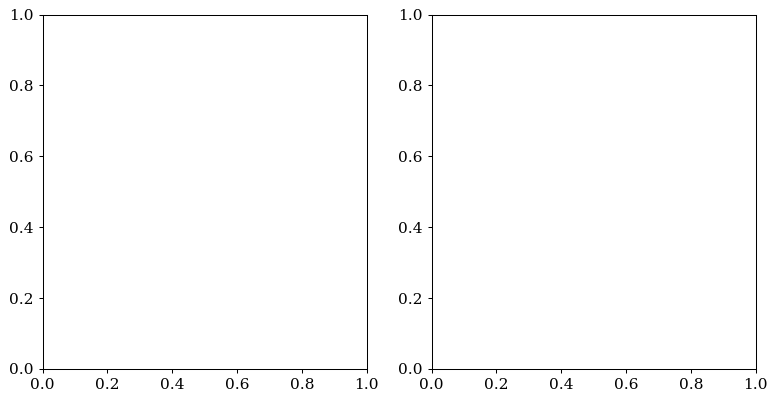

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(andata,X_umap_label = "X_umap", column = "cluster",ax = ax[0],s = 0.01)
plot_umap(andata,X_umap_label = "X_umap", column = "batch",paletteSel = 'Set2',ax = ax[1],s = 0.01,colorbar = False)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)


In [20]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
andata_save = andata.copy()
andata_save.write_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony_scvi_celltyping.h5ad"))

... storing 'low_major' as categorical
... storing 'ref_major' as categorical


### cell2location


```bash
module load cell2location/0.1.4 
/usr/local/apps/cell2location/0.1.4/bin/jupyter notebook --ip localhost --port $PORT1 --no-browser 
```

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
import gzip
import numpy as np
import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

In [4]:
pathout  = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
results_folder = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/results_spec/cell2loc'

/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


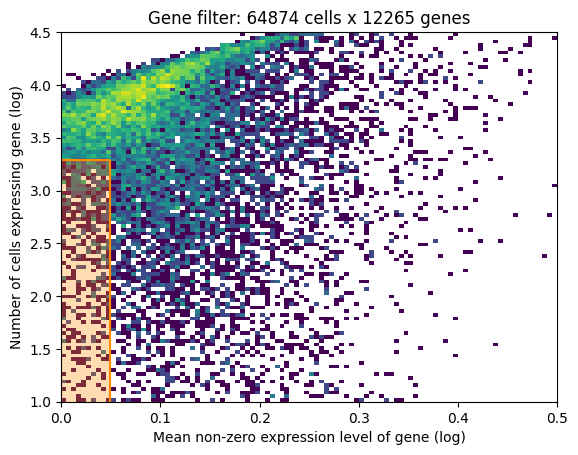

In [3]:
adata_ref = sc.read_h5ad(os.path.join(pathout, "reff_scData_melanoma_skin_log_norm.h5ad"))
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

In [4]:
adata_ref = adata_ref[:, selected].copy()
adata_ref

AnnData object with n_obs × n_vars = 64874 × 12265
    obs: 'sex', 'tissue', 'CellType'
    var: 'n_cells', 'nonz_mean'
    uns: 'log1p'
    layers: 'counts'

In [5]:
adata_ref.X = adata_ref.layers['counts']

In [6]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='tissue',
                        # cell type, covariate used for constructing signatures
                        labels_key='CellType',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['sex'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 22 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [7]:
mod = RegressionModel(adata_ref)

In [8]:
mod.train(max_epochs=250)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.4/lib/p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLU

Epoch 250/250: 100%|█████████████████████████████████| 250/250 [18:27<00:00,  4.59s/it, v_num=1, elbo_train=3.7e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█████████████████████████████████| 250/250 [18:27<00:00,  4.43s/it, v_num=1, elbo_train=3.7e+8]


/tmp/ipykernel_2405538/94219018.py:2: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  mod.plot_history(20)


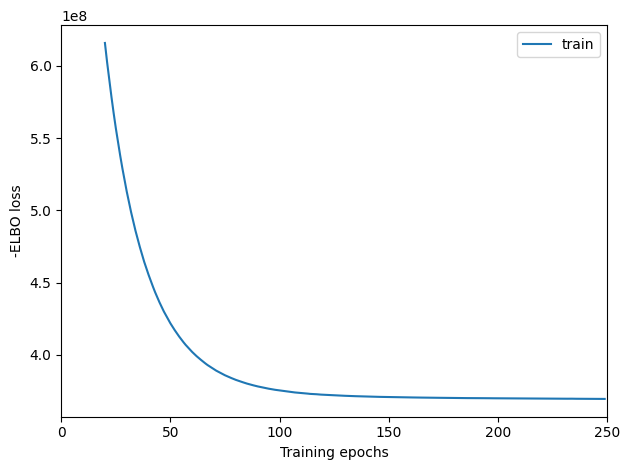

In [9]:
with PdfPages(os.path.join(results_folder, f'ELBO_loss_history.pdf')) as pdf:
    mod.plot_history(20)

In [10]:
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000,'batch_size': 2500})



Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.4/lib/p ...


Sampling global variables, sample: 100%|█████████████████████████████████████████| 999/999 [00:12<00:00, 77.92it/s]


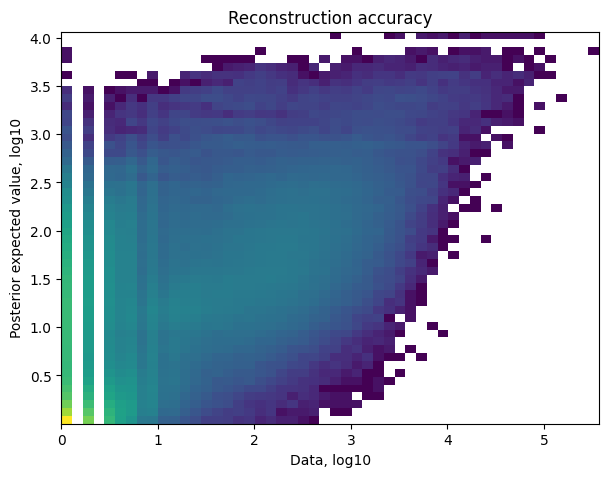

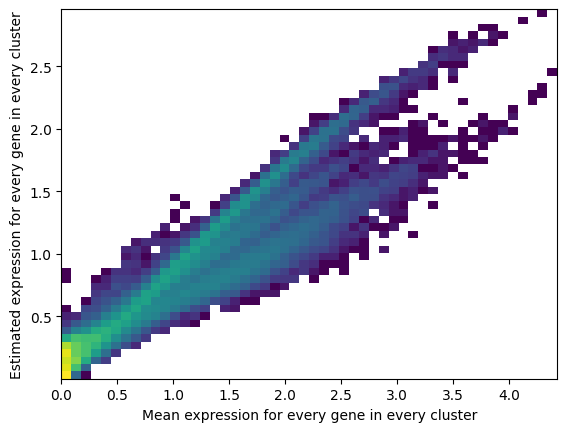

/tmp/ipykernel_2405538/1131898005.py:2: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  mod.plot_QC()


In [11]:
with PdfPages(os.path.join(results_folder, f'adata_ref_QC_plots.pdf')) as pdf:
    mod.plot_QC()

In [12]:
# mod.save(f"{ref_run_name}", overwrite=True)
inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']


In [62]:
# load target data:
andtata_in = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony_scvi_con_mouse_cov.h5ad"))
andtata_in.X = andtata_in.layers['counts']
#sc.pp.normalize_total(andtata_in)
#sc.pp.log1p(andtata_in)

In [66]:
andtata_in = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony_scvi_con_mouse_cov.h5ad"))
andtata_in

AnnData object with n_obs × n_vars = 664093 × 2000
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier', 'cluster', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_pca_Harmony', 'X_pca_before', 'X_scVI', '_scvi_extra_categorical_covs', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [14]:
Experimental_design_file = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/Experimental_design/Experimental_Design.csv'
ed = pd.read_csv(Experimental_design_file)


column_sel = ed.columns[2:4].tolist()+ed.columns[5:11].tolist()
covariateTOnum = {}
numTOcovariate = {}
for column in column_sel:
    un_name_temp = pd.unique(ed[column].values)
    covariateTOnum[column] = {c:i for i,c in enumerate(un_name_temp)}
    numTOcovariate[column] = {i:c for i,c in enumerate(un_name_temp)}
for column in column_sel:
    dict_temp = covariateTOnum[column]
    list_temp = [dict_temp[i] for i in ed[column].values]
    ed[column] = list_temp

from tqdm import tqdm
# adding covrites per batch to andata
for column in column_sel:
    andtata_in.obs[column] = None
    for batch in tqdm(ed['Polygon']):
        covraite_temp = ed.loc[ed["Polygon"]==batch,column].values.tolist()*len(andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch),column])
        andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch),column] = covraite_temp

100%|█████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 254.07it/s]


In [15]:
intersect = np.intersect1d(andtata_in.var_names, inf_aver.index)
adata_vis = andtata_in[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

#cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key='batch',categorical_covariate_keys = ['Sample_ID','Condition ','Technical_repeat','Mouse_ID', 'Harvest_Day', 'Size', 'Immune_Cell' ])
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key='batch',categorical_covariate_keys = ['Condition ','Mouse_ID'])

mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=25,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)

In [16]:
#mod.train(max_epochs=100,batch_size=3000,train_size=1)

#with PdfPages(os.path.join(results_folder, f'cell2loc_model.pdf')) as pdf:
    #mod.plot_history(1000)
    #plt.legend(labels=['full data training'])
    

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.4/lib/p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLU

Epoch 1000/1000: 100%|██████████████████████████| 1000/1000 [4:24:02<00:00, 15.42s/it, v_num=1, elbo_train=9.24e+8]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████████████████████| 1000/1000 [4:24:02<00:00, 15.84s/it, v_num=1, elbo_train=9.24e+8]


/tmp/ipykernel_2405538/4159452259.py:5: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  plt.legend(labels=['full data training'])


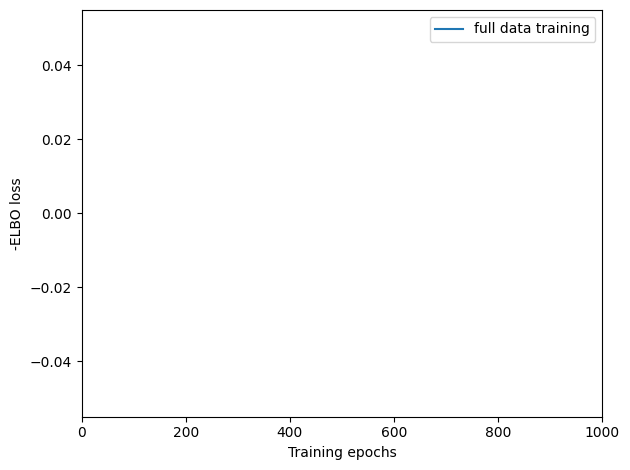

In [17]:
mod.train(max_epochs=1000,batch_size=3000,train_size=1)

with PdfPages(os.path.join(results_folder, f'cell2loc_model.pdf')) as pdf:
    mod.plot_history(1000)
    plt.legend(labels=['full data training'])
    


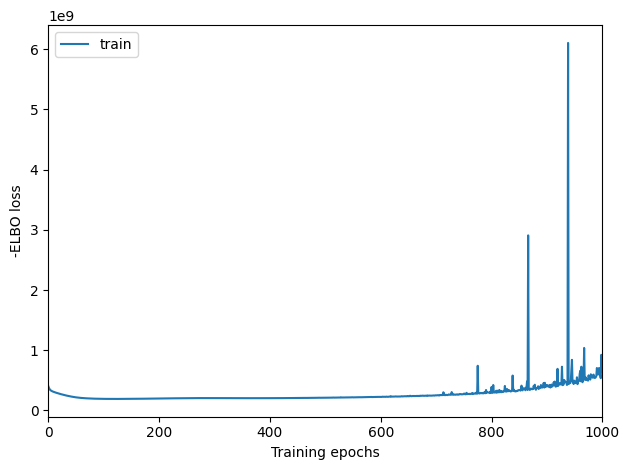

In [20]:
mod.plot_history()

In [ ]:
adata_vis

In [31]:
results_folder

'/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/results_spec/cell2loc'

In [22]:
adata_vis = mod.export_posterior(
    adata_vis,
    use_quantiles = True,
)


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/usr/local/apps/cell2location/conda/envs/0.1.4/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.4/lib/p ...
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


In [39]:
mod.save(f"{results_folder}", overwrite=True)

In [32]:
adata_save = adata_vis.copy()

In [34]:
del andata_save.obs['Sample_ID']
del adata_save.obs['Condition ']
del adata_save.obs['Technical_repeat']
del adata_save.obs['Mouse_ID']
del adata_save.obs['Harvest_Day']
del adata_save.obs['Harvest_Date']
del adata_save.obs['Size']
del adata_save.obs['Immune_Cell']

In [38]:
adata_save.write(os.path.join(results_folder, "adata_vis.h5ad"))

<center><h3>Spatial mapping of cell types across Batches </h3>

https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo_downstream.html?highlight=heatmap

In [5]:
adata_vis = sc.read_h5ad(os.path.join(results_folder, "adata_vis.h5ad"))

In [12]:
adata_vis.uns['spatial'] = adata_vis.obsm['spatial']

In [15]:
# create a spatial keys for coll2location
adata_vis.uns['spatial'][0]

array([8879.53808594, 6808.59716797])

In [47]:
from cell2location.plt.mapping_video import plot_spatial

In [19]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """
    slide = adata[s in adata.obs[s_col],:].copy()
    return slide

In [20]:
pd.unique(adata_vis.obs['batch'])

['41', '16', '46', '59', '34', ..., '31', '0', '43', '44', '42']
Length: 62
Categories (62, object): ['41', '16', '46', '59', ..., '0', '43', '44', '42']

In [22]:
sel_clust = adata_vis.uns['mod']['factor_names']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]
#slide = select_slide(adata_vis, s = '58',s_col = 'batch')
slide = select_slide(adata_vis, s = '58',s_col = 'batch')

In [26]:
slide.obs.columns

Index(['cell_id', 'transcript_counts', 'control_probe_counts',
       'genomic_control_counts', 'control_codeword_counts',
       'unassigned_codeword_counts', 'deprecated_codeword_counts',
       'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count',
       'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts',
       'outlier', 'cluster', '_indices', '_scvi_batch', '_scvi_labels'],
      dtype='object')

In [30]:
adata_vis

AnnData object with n_obs × n_vars = 664093 × 1446
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier', 'cluster', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'mod', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'X_pca_Harmony', 'X_pca_before', '_scvi_extra_categorical_covs', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'l

In [10]:
adata_vis.obsm['X_cell2loc'] = adata_vis.obsm['q05_cell_abundance_w_sf'].to_numpy()

In [ ]:
adata_vis.obsm['X_cell2loc'].shape

In [ ]:
sc.pp.neighbors(adata_vis, n_pcs = 56, use_rep =  'X_cell2loc',key_added = 'cell2locNigb')

In [ ]:
sc.tl.leiden(adata_concat, random_state=1337, resolution=0.667, key_added='cluster_cell2loc', neighbors_key='cell2locNigb')

In [ ]:
def plot_spatial(andata,ax, cluster = 'cluster', features = None,title = '',xlab = '',ylab ='',size = 2,alpha = 0.6, markerscale = 5, cluster_name = 'cluster'):
    palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")
    df = pd.DataFrame({'cluster':andata.obs[cluster],'x':andata.obsm['spatial'][:,0],'y':andata.obsm['spatial'][:,1]})
    if features:
        df[df['cluster'].isin([features])]
    num_classes = len(df['cluster'].unique())
    if num_classes==1:
        listed_cmap = ListedColormap(palette)
    else:
        num_classes = len(np.unique(df['cluster'].values))
        extended_palette = palette * (num_classes // len(palette) + 1)
        extended_palette = extended_palette[:num_classes]
        listed_cmap = ListedColormap(extended_palette)
    color_container = []
    
    clusters = sorted(np.unique(df['cluster'].values), key=int)
    for i, cluster in enumerate(clusters):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter( x=cluster_data['x'], y=cluster_data['y'], color=listed_cmap(i), label=f'{cluster}', s=size, alpha=alpha)
        color_container.append(listed_cmap(i))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    legend = ax.legend( title=cluster_name,
                        bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
                        loc='upper left',
                        fontsize='small',  # Control the font size
                        title_fontsize='medium',
                        markerscale=markerscale,  # Increase the size of the legend markers
                        frameon=False# Control the title font size
                        )
    df_color = pd.DataFrame({"clusters":df['cluster'].unique(),"colors":color_container})
    return df_color

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plt.rcParams['figure.dpi'] = 800
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
clusterColorMap = plot_spatial(andata,ax = ax,cluster = 'spatialleiden', features = None, title = '',markerscale = 30, xlab = '',ylab ='',size = 0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

### STAligner

source myconda  
mamba activate STAligner_env 
jupyter notebook --ip localhost --port $PORT1 --no-browser 

In [4]:
import STAligner
import os

import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import scipy
import networkx

import torch

used_device = torch.device('cuda')

In [5]:
import scanpy as sc
print(sc.__version__)

1.9.1


In [6]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [26]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
andtata_in = sc.read_h5ad(os.path.join(pathout, "andata_minimum_forSTAligner.h5ad"))

In [27]:
unique_batch = pd.unique(andtata_in.obs["batch"].astype(str))

In [28]:
Batch_list = []
adj_list = []

for i,p in enumerate(unique_batch):
    adata = andtata_in[andtata_in.obs["batch"]==p,:]
    STAligner.Cal_Spatial_Net(adata)  
    
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)
    del adata 

------Calculating spatial graph...
The graph contains 0 edges, 17758 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 15588 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 12590 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 8973 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 14779 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 10714 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 3867 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 13808 cells.
0.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 0 edges, 8831 cells.
0.0000 neighbor

In [29]:
adata_concat = ad.concat(Batch_list, label="batch", keys=unique_batch.tolist())
adata_concat.obs["batch_name"] = adata_concat.obs["batch"].astype('category')

In [31]:
path_temp = "/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/staligner_temp"
andata_save = adata_concat.copy()
andata_save.write_h5ad(os.path.join(path_temp, "andata_stalignTemp.h5ad"))

In [18]:
def memory_efficient_block_diag(adj_list):
    """
    Constructs a block diagonal matrix from a list of sparse adjacency matrices in a memory-efficient way.
    
    Parameters:
        adj_list (list): A list of sparse matrices (scipy.sparse).

    Returns:
        scipy.sparse.csr_matrix: Block diagonal sparse matrix.
    """
    # Calculate the total size of the final matrix
    total_rows = sum(adj.shape[0] for adj in adj_list)
    total_cols = sum(adj.shape[1] for adj in adj_list)

    # Initialize sparse matrices for the data, row indices, and column indices
    data = []
    row_indices = []
    col_indices = []

    row_offset = 0
    col_offset = 0

    for adj in adj_list:
        # Convert sparse matrix to COO format for efficient indexing
        adj_coo = adj.tocoo()

        # Append the data and adjusted indices
        data.append(adj_coo.data)
        row_indices.append(adj_coo.row + row_offset)
        col_indices.append(adj_coo.col + col_offset)

        # Update offsets for the next block
        row_offset += adj.shape[0]
        col_offset += adj.shape[1]

    # Concatenate data and indices from all blocks
    data = np.concatenate(data)
    row_indices = np.concatenate(row_indices)
    col_indices = np.concatenate(col_indices)

    # Construct the final sparse matrix
    block_diag_matrix = sp.csr_matrix((data, (row_indices, col_indices)), shape=(total_rows, total_cols))
    return block_diag_matrix

In [19]:
adj_concat = memory_efficient_block_diag(adj_list)
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

In [25]:
path_temp = "/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/staligner_temp"
andata_save = adata_concat.copy()
andata_save.write_h5ad(os.path.join(path_temp, "andata_stalignTemp.h5ad"))

IORegistryError: No method registered for writing <class 'tuple'> into <class 'h5py._hl.group.Group'>

Above error raised while writing key 'edgeList' of <class 'h5py._hl.group.Group'> to /

In [22]:
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 10,margin=1, iter_comb = None,  device=used_device)

STAligner(
  (conv1): GATConv(2000, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2000, heads=1)
)
Pretrain with STAGATE...


  0%|                                                                                      | 0/500 [00:00<?, ?it/s]


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`